In [66]:
import numpy as np
import gensim
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, Embedding, Flatten, merge
from keras.optimizers import Adam
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.visualize_util import plot
from keras.utils.visualize_util import model_to_dot
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
import pickle
import pandas as pd

In [4]:
corpora = gensim.corpora.Dictionary.load('./data/corpora.dat')
vocab_size = len(corpora)
print('Number of words in corpora: %d'%(vocab_size))

Number of words in corpora: 26


In [5]:
tmp = list(corpora.items())

In [6]:
#the_filename = './data/wonderland.txt.dat'
the_filename = './data/test.txt.dat'
with open(the_filename, 'rb') as f:
    text = pickle.load(f)

### Generate words patterns - 2 words model

In [7]:
cs = 2

In [8]:
c_in_dat = [[text[i+n] for i in range(0, len(text)-cs, cs)]
            for n in range(cs)]

In [9]:
print( [corpora.id2token[text[i+0]] for i in range(0, len(text)-cs, cs)] )
print( [corpora.id2token[text[i+1]] for i in range(0, len(text)-cs, cs)] )
print( [corpora.id2token[text[i+cs]] for i in range(0, len(text)-cs, cs)] )

['One', 'three', 'five', 'seven', 'nine', '.', 'quick', 'fox', 'over', 'lazy', '.', 'are', '?', 'are']
['two', 'four', 'six', 'eight', 'ten', 'The', 'brown', 'jumps', 'a', 'dog', 'How', 'you', 'What', 'you']
['three', 'five', 'seven', 'nine', '.', 'quick', 'fox', 'over', 'lazy', '.', 'are', '?', 'are', 'doing']


In [10]:
c_out_dat = [text[i+cs] for i in range(0, len(text)-cs, cs)]

In [11]:
xs = [np.stack(c[:-2]) for c in c_in_dat]

In [12]:
len(xs), xs[0].shape

(2, (12,))

In [13]:
y = np.stack(c_out_dat[:-2])

In [14]:
[xs[n][:cs] for n in range(cs)]

[array([2, 4]), array([0, 8])]

In [15]:
y[:cs]

array([4, 3])

In [16]:
n_fac = 4

In [17]:
### Create and train model

In [18]:
def embedding_input(name, n_in, n_out):
    inp = Input(shape=(1,), dtype='int64', name=name+'_in')
    emb = Embedding(n_in, n_out, input_length=1, name=name+'_emb')(inp)
    return inp, Flatten()(emb)

In [19]:
c_ins = [embedding_input('c'+str(n), vocab_size, n_fac) for n in range(cs)]

In [20]:
n_hidden = 256

In [21]:
dense_in = Dense(n_hidden, activation='relu')
dense_hidden = Dense(n_hidden, activation='relu', init='identity')
dense_out = Dense(vocab_size, activation='softmax')

In [22]:
hidden = dense_in(c_ins[0][1])

In [23]:
for i in range(1,cs):
    c_dense = dense_in(c_ins[i][1])
    hidden = dense_hidden(hidden)
    hidden = merge([c_dense, hidden])

In [24]:
c_out = dense_out(hidden)

In [25]:
model = Model([c[0] for c in c_ins], c_out)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam())

In [26]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
c0_in (InputLayer)               (None, 1)             0                                            
____________________________________________________________________________________________________
c1_in (InputLayer)               (None, 1)             0                                            
____________________________________________________________________________________________________
c0_emb (Embedding)               (None, 1, 4)          104         c0_in[0][0]                      
____________________________________________________________________________________________________
c1_emb (Embedding)               (None, 1, 4)          104         c1_in[0][0]                      
___________________________________________________________________________________________

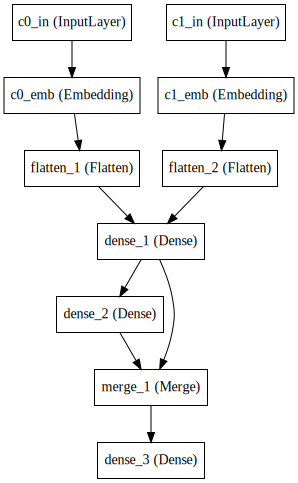

In [27]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [28]:
model.fit(xs, y, batch_size=1, nb_epoch=100)

Epoch 1/100
12/12 [==============================] - 0s - loss: 3.2675     
Epoch 2/100
12/12 [==============================] - 0s - loss: 3.2090     
Epoch 3/100
12/12 [==============================] - 0s - loss: 3.1374     
Epoch 4/100
12/12 [==============================] - 0s - loss: 3.0156     
Epoch 5/100
12/12 [==============================] - 0s - loss: 2.8115     
Epoch 6/100
12/12 [==============================] - 0s - loss: 2.5802     
Epoch 7/100
12/12 [==============================] - 0s - loss: 2.3976     
Epoch 8/100
12/12 [==============================] - 0s - loss: 2.2692     
Epoch 9/100
12/12 [==============================] - 0s - loss: 2.2005     
Epoch 10/100
12/12 [==============================] - 0s - loss: 2.1037     
Epoch 11/100
12/12 [==============================] - 0s - loss: 1.9401     
Epoch 12/100
12/12 [==============================] - 0s - loss: 1.8104     
Epoch 13/100
12/12 [==============================] - 0s - loss: 1.6343     
Epoch 14

In [29]:
model.save('./models/dev_fast_ai_first_RNN.h5')

## Test model

In [30]:
def get_next_multi(inp):
    idxs = [corpora.token2id[c] for c in inp]
    print(idxs)
    arrs = [np.array(i)[np.newaxis] for i in idxs]
    print(arrs)
    
    p = model.predict(arrs)
    print(p.shape)
    i_max1 = np.argmax(p)
    p[0,i_max1] = 0
    i_max2 = np.argmax(p)
    p[0,i_max2] = 0
    i_max3 = np.argmax(p)

    
    return corpora.id2token[i_max1], corpora.id2token[i_max2], corpora.id2token[i_max3]

In [31]:
def get_next(inp):
    idxs = [corpora.token2id[c] for c in inp]
    #print(idxs)
    arrs = [np.array(i)[np.newaxis] for i in idxs]
    #print(arrs)
    
    p = model.predict(arrs)
    #print(p.shape)
    i_max1 = np.argmax(p)
    #p[0,i_max1] = 0
    #i_max2 = np.argmax(p)
    #p[0,i_max2] = 0
    #_max3 = np.argmax(p)

    
    return corpora.id2token[i_max1]#, corpora.id2token[i_max2], corpora.id2token[i_max3]

In [32]:
get_next(['One', 'two'])

'three'

In [54]:
test_cases_text = pd.read_csv('./data/test_cases_text.csv')
pred = []
for index, row in test_cases_text.iterrows():
    #print( '%s %s'%(row['in_0'], row['in_1']))
    inp = [row['in_0'], row['in_1']]
    #print(inp)
    tmp = get_next(inp)
    pred.append(tmp)
test_cases_text['predicted'] = pred

In [67]:
pd.crosstab(test_cases_text['out'], test_cases_text['predicted'])

predicted,.,?,are,five,fox,lazy,nine,over,quick,seven,three
out,,,,,,,,,,,
.,2,0,0,0,0,0,0,0,0,0,0
?,1,1,0,0,0,0,0,0,0,0,0
How,0,0,0,0,0,0,1,0,0,0,0
The,0,0,0,1,0,0,0,0,0,0,0
What,1,0,0,0,0,0,0,0,0,0,0
a,0,0,0,0,0,0,0,0,0,1,0
are,0,0,1,0,0,0,0,0,0,0,1
brown,0,0,0,0,0,0,0,0,0,0,1
dog,0,0,0,0,0,0,0,1,0,0,0


In [77]:
test_cases_text[test_cases_text.out==test_cases_text.predicted]

,in_0,in_1,out,predicted
0,One,two,three,three
2,three,four,five,five
4,five,six,seven,seven
6,seven,eight,nine,nine
8,nine,ten,.,.
10,.,The,quick,quick
12,quick,brown,fox,fox
14,fox,jumps,over,over
16,over,a,lazy,lazy
18,lazy,dog,.,.


In [78]:
true_cnt = len(test_cases_text[test_cases_text.out==test_cases_text.predicted].index) * 1.0
all_cnt = len(test_cases_text.index) * 1.0
print('True cnt: %d All cnt %d'%(true_cnt, all_cnt))
print("Precision: %.2f"%( true_cnt/all_cnt))

True cnt: 12 All cnt 28
Precision: 0.43
